# 주제: 뉴스 기사 요약해보기

## 데이터
뉴스 기사 데이터: https://github.com/sunnysai12345/News_Summary  

## 목표
1. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.  
2. 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.  
3. 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.  

## Step 1. 데이터 수집하기

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import re
import matplotlib.pyplot as plt

from importlib.metadata import version
import summa
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tf.__version__)
print(version('summa'))

3.6.5
2.6.0
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [15]:
data.sample(10)

,headlines,text
15999,"After mutual funds, Paytm Money may offer shar...",Paytm's wealth management subsidiary Paytm Mon...
72362,Arun Gawli denied parole to attend premiere of...,Gangster-turned-politician Arun Gawli has been...
18795,Give list of people who went with PM Modi on f...,Central Information Commission has directed th...
814,"Bharat needs Eid release, couldn't fit in time...","Katrina Kaif, who opted out of choreographer-f..."
60228,Start time of first 2 ODIs vs SL changed owing...,The BCCI has changed the start timings of the ...
67714,Tom Alter wanted MS Dhoni banned after he reti...,Late actor Tom Alter wanted Mahendra Singh Dho...
2093,US woman turns 110-year-old tree in her yard i...,A woman in the US state of Idaho has turned a ...
28113,Nobel laureate Satyarthi launches app to track...,"Nobel Peace Prize recipient Kailash Satyarthi,..."
79662,"Thousands of cockroaches flood street, task fo...",Thousands of cockroaches emerged from a sewer ...
3282,"Cong an insignificant force in UP, don't need ...","Calling Congress an ""insignificant force"" in U..."


## Step 2. 데이터 전처리하기 (추상적 요약)

### (1) 데이터 전처리

In [16]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [17]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [18]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [19]:
# 텍스트 정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [20]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [21]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [24]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않는다

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [22]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸림
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [25]:
clean_summary = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있다.
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [26]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [27]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [28]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### (2) 훈련데이터와 테스트 데이터 분리하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


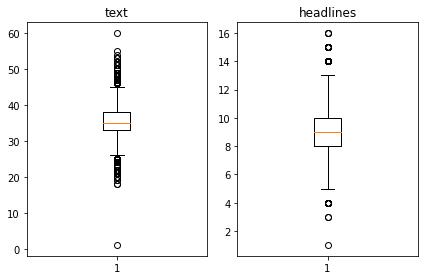

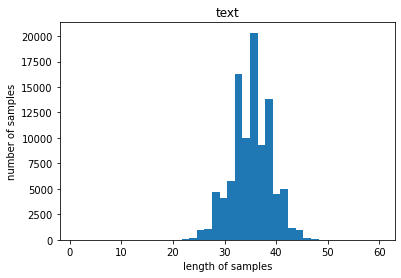

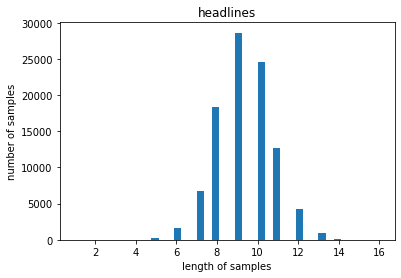

In [29]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(summary_len)))
print('제목의 최대 길이 : {}'.format(np.max(summary_len)))
print('제목의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
text_max_len = 40
summary_max_len = 10
print('=3')

=3


In [34]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [35]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [36]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74102


In [37]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [38]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [39]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[35275  4528 68772 ... 13767  3984 63044]


In [40]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [41]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14820


In [42]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### (3) 단어 집합(vocabulary) 만들기: 정수 인코딩

- 인코더

In [43]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [44]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61550
등장 빈도가 6번 이하인 희귀 단어의 수: 42220
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19330
단어 집합에서 희귀 단어의 비율: 68.59463850528026
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.191856922113868


In [45]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [46]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[67, 61, 5681, 1979, 13762, 1420, 574, 1548, 190, 61, 678, 6884, 156, 1798, 5196, 14389, 996, 1537, 947, 362, 11, 245, 7963, 156, 6435, 568, 67], [21, 523, 13763, 49, 997, 160, 1354, 2, 15, 39, 4120, 1154, 5538, 37, 61, 2240, 520, 39, 476, 748, 114, 3141, 39, 959, 1602, 765, 37, 160, 84, 71, 1487, 843], [27, 21, 52, 1065, 5909, 13764, 3405, 29, 184, 306, 23, 2263, 506, 2014, 71, 94, 10, 71, 3405, 996, 58, 326, 1311, 13764, 3405, 956, 92, 29, 38, 74, 53]]


- 디코더

In [47]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [48]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27367
등장 빈도가 5번 이하인 희귀 단어의 수: 18334
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9033
단어 집합에서 희귀 단어의 비율: 66.99309387218183
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.998667687648298


In [49]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 34, 1848, 4, 6, 289], [1, 336, 20, 63, 82, 964, 5, 748, 1412, 600], [1, 6976, 2010, 536, 35, 272, 768, 4, 45, 38, 3127], [1, 116, 88, 392, 436, 1442, 15, 1283, 87, 6498], [1, 528, 74, 1919, 891, 4, 645, 2296, 6, 437, 182]]
target
decoder  [[34, 1848, 4, 6, 289, 2], [336, 20, 63, 82, 964, 5, 748, 1412, 600, 2], [6976, 2010, 536, 35, 272, 768, 4, 45, 38, 3127, 2], [116, 88, 392, 436, 1442, 15, 1283, 87, 6498, 2], [528, 74, 1919, 891, 4, 645, 2296, 6, 437, 182, 2]]


- 빈 데이터 삭제

In [50]:
# 빈 데이터가 되어버린 데이터들 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 59281
훈련 레이블의 개수 : 59281
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


- 패딩

In [51]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [56]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [57]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [58]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [59]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [60]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') # 시간이 20분 이상 걸림
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 57s 82ms/step - loss: 6.3071 - val_loss: 5.9003
Epoch 2/50
232/232 [==============================] - 18s 78ms/step - loss: 5.7600 - val_loss: 5.5388
Epoch 3/50
232/232 [==============================] - 18s 79ms/step - loss: 5.4163 - val_loss: 5.2760
Epoch 4/50
232/232 [==============================] - 19s 80ms/step - loss: 5.1219 - val_loss: 5.0382
Epoch 5/50
232/232 [==============================] - 19s 82ms/step - loss: 4.8808 - val_loss: 4.8883
Epoch 6/50
232/232 [==============================] - 19s 83ms/step - loss: 4.6862 - val_loss: 4.7821
Epoch 7/50
232/232 [==============================] - 20s 85ms/step - loss: 4.5223 - val_loss: 4.6767
Epoch 8/50
232/232 [==============================] - 20s 85ms/step - loss: 4.3715 - val_loss: 4.5932
Epoch 9/50
232/232 [==============================] - 19s 84ms/step - loss: 4.2374 - val_loss: 4.5363
Epoch 10/50
232/232 [==============================] - 19s 84ms/step - loss: 4.114

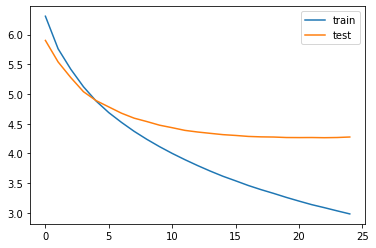

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

-> 약간의 오버피팅이 있지만 train, test 둘다 loss가 줄어다는 것을 확인할 수 있다.

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [62]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [63]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [64]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [65]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [66]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 제목의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [67]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 제목 :", seq2summary(decoder_input_test[i]))
    print("예측 제목 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : reacting recent violence africans india group african said india took action prevent violence africans properly condemn greater noida attack also termed attacks african nationals india racial sought international inquiry matter along demanding strong 
실제 요약 : india did not act to stop violence against envoys 
예측 요약 :  no proof for violence on the journalists activist


원문 : nia court convicted people organising secret camp banned outfit students islamic movement india kerala acquitted others many terror cases birth terror group indian mujahideen traced camp reports said founding member indian mujahideen abdul qureshi also attended camp 
실제 요약 : convicted of organising banned outfit camp in kerala 
예측 요약 :  myanmar cops who to stop crimes against terrorism


원문 : team ed cbi london holding talks uk prosecutors extradition vijay mallya agencies briefing authorities highest level plug loopholes used official said home secretary level talks ensure uk government board indian authoritie

예측 요약 :  yr old baby dies after falling into mumbai


원문 : least six people killed four injured sunday collision two speeding cars karnataka head collision occurred due fog lack lights reports said case registered police investigation underway 
실제 요약 : killed injured in car collision in karnataka 
예측 요약 :  killed injured in car crash in bihar


원문 : cops punjab filed case police station alleged theft electricity notably rules mandate fir lodged living entities punjab state power corporation limited official said surprised charge booked instead police station 
실제 요약 : cops file case against police station over electricity theft 
예측 요약 :  fir against cops for not in haryana


원문 : site wikileaks claimed us cryptocurrency exchange coinbase closed account opened online store allegedly violating terms service wikileaks shop said action taken coinbase without notice explanation response wikileaks called global boycott coinbase calling unfit member crypto community 
실제 요약 : us crypto exchange

예측 요약 :  us troops in us to korea


원문 : leak detected international space station wednesday night believed caused rocky space cabin pressure drop traced hole measuring millimetres russian side space station however hole using tape six member crew safe said nasa 
실제 요약 : leak detected aboard the international space station 
예측 요약 :  nasa captures ice from space station


원문 : delhi electricity regulatory commission notified new rule consumers compensated power distribution companies restore outage two three hours consumers get compensation per kw per hour power distribution companies scheme comes effect september 
실제 요약 : delhi power suppliers to pay consumers for long power cuts 
예측 요약 :  delhi govt clears deadline to reduce dengue cases


원문 : lok sabha wednesday passed bill proposing protect unauthorised slums colonies delhi disciplinary action three years existing deadline relocate slums colonies december centre said regulatory authorities still carrying surveys deal encroachments 

- 첫 번째 text  

원문:최근의 폭력에 대응하는 아프리카 인디아 그룹 아프리카는 아프리카인들이 폭력을 적절히 방지하기 위해 조치를 취했다고 말했습니다. 또한 아프리카인들은 공격이라고도 불리는 더 큰 노이다 공격을 비난합니다. 인도 인종은 강력한 요구와 함께 국제 조사 문제를 추구했습니다   
실제 제목: 인도는 사절에 대한 폭력을 멈추기 위해 행동하지 않았습니다   
예측 제목: 언론인 활동가에 대한 폭력에 대한 증거 없음  

- 두 번째 text  

원문: 나이아 법원은 비밀 캠프를 조직한 사람들에게 유죄 판결을 내렸습니다. 학생들의 이슬람 운동 금지 의상을 입은 인도 케랄라는 다른 많은 테러 사건들에 무죄를 선고했습니다. 탄생 테러 단체인 인도 무자헤딘은 캠프 보고서에서 창립 멤버인 인도 무자헤딘 압둘 쿠레시도 캠프에 참석했다고 말했습니다   
실제 제목: 케랄라에서 금지된 의상 캠프를 조직한 혐의로 유죄 판결을 받았습니다   
예측 제목: 테러에 대한 범죄를 저지하기 위한 미얀마 경찰  

- 열 번째 text  

원문: 테스트를 거친 거의 고유의 아카시 미사일이 결함이 있는 것으로 판명된 감사원 보고서는 미사일 제조 상태에서 바라트 전자 제한 시험 발사 6개의 실패한 시험 미사일이 목표물에 미달하는 저속 임계 장치 오작동 보고서를 추가했습니다   
실제 제목: 인도는 실패율이 보고된 캐시 미사일을 만들었습니다   
예측 제목: 우리는 처음으로 성공적으로 화재를 테스트했습니다  

-> 파파고 번역기를 이용해서 확인해 보았을 때 번역 상태가 완벽하지는 않지만 대체로 원문에 있는 내용의 핵심 단어들을 사용하며 원문에는 없는 단어를 새롭게 생성하여 문장을 완성하는 것을 볼 수 있다. 두 번째 text를 보면 굉장히 적절한 제목을 잘 지었지만 첫 번째 text와 열 번째 text는 내용은 잘 담아냈지만 그 방향이 완전히 반대가 되어 다른 내용의 기사 제목이 되어버리는 경우도 있다. 

## Step 5. Summa을 이용해서 추출적 요약해보기

In [ ]:
#$ pip list | grep summa

In [68]:
import requests
from summa.summarizer import summarize

In [74]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [75]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [76]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.4)) # 5분정도 걸린다

In [77]:
data.head()

,headlines,text,summary
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...","Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...


In [81]:
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 제목 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 제목 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 제목 : Delhi techie wins free food from Swiggy for one year on CRED
추출 요약 : Users get one CRED coin per rupee of bill pai

- 첫 번째 headlines   

원문: upgrad와 IIIT-B의 기계 학습 및 인공 지능 분야 PG 프로그램 졸업생인 Saurav Kant는 Infosys의 Sr Systems Engineer로 거의 5년의 업무 경험이 있습니다. 이 프로그램과 upGrad의 360도 경력 지원 덕분에 Tech Mahindra의 데이터 사이언티스트로 전환할 수 있었고 급여는 90% 인상되었습니다. UpGrad의 온라인 파워 러닝은 3개 이상의 경력을 쌓았습니다.  
실제 제목: upgrad 학습자는 90%의 급여 인상으로 ML & Al에서 경력으로 전환합니다  
추출 요약: upGrad의 온라인 파워 러닝은 3개 이상의 경력을 쌓았습니다.  

- 두 번째 headlines  

원문: Kunal Shah의 신용카드 결제 플랫폼인 CRED는 사용자들에게 1년 동안 Swiggy로부터 무료 음식을 얻을 수 있는 기회를 주었습니다. 델리의 기술자인 Pranav Kaushik은 2000개의 크레디트 동전을 쓴 후에 이 보상을 챙겼습니다. 사용자는 지불된 청구서의 루피 당 1개의 크레디트 코인을 받을 수 있으며, 이는 Ixigo, Book MyShow, UberEats, Cult와 같은 브랜드의 보상을 이용하는 데 사용될 수 있습니다.핏 그 이상.  
실제 제목: Delhi Techie는 CED에서 Swiggy로부터 1년간 무료 음식을 획득했습니다  
추출 요약: 사용자는 지불된 청구서의 루피 당 1개의 크레디트 코인을 받을 수 있으며, 이는 Ixigo, Book MyShow, UberEats, Cult와 같은 브랜드의 보상을 이용하는 데 사용될 수 있습니다.핏 그 이상.  

- 열 번째 headlines  

원문: 의회 후보 Shafia Zubair는 보궐선거에서 12,228표 차이로 BJP의 Sukhwant Singh를 꺾고 라자스탄의 람가르 의회 의석을 차지했습니다. 이번 승리로, 의회는 200명의 의원 중에서 총 100석을 차지했습니다. 람가르 의석의 선거는 현직 MLA와 BSP 후보인 락스만 싱의 사망으로 인해 연기되었습니다.  
실제 제목: 라자스탄에서 실시된 람가르 바이 여론조사에서 승리한 의회는 총 100석을 차지합니다  
추출 요약: 의회 후보 Shafia Zubair는 보궐선거에서 12,228표 차이로 BJP의 Sukhwant Singh를 꺾고 라자스탄의 람가르 의회 의석을 차지했습니다.  

## step6. 결과 분석
### (1) 자세한 분석

- Attention 10번째 문장   

원문 : lok sabha wednesday passed bill proposing protect unauthorised slums colonies delhi disciplinary action three years existing deadline relocate slums colonies december centre said regulatory authorities still carrying surveys deal encroachments take time 
실제 요약 : lok sabha passes bill to protect unauthorised delhi 
예측 요약 :  bill to pay for lakh to increase bill sabha
-> 이 글의 핵심 단어는 테스트를 진행했다는 점과 처음으로 오작동 보고서를 제출했다는 단어이다. 예측 요약에서 테스트를 진행했다는 내용이 포함되어 있지만 오작동 보고서를 처음으로 제출한 것이 아니라 테스트 성공을 처음으로 했다는 식으로 요약이 되어 있어서 정확도가 80%정도라고 볼 수 있다. 

- summa 10번째 문장  

원문 : Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll. With this victory, Congress has taken its total to 100 seats in the 200-member assembly. The election to the Ramgarh seat was delayed due to the death of sitting MLA and BSP candidate Laxman Singh.
실제 제목 : Cong wins Ramgarh bypoll in Rajasthan, takes total to 100 seats
추출 요약 : Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll.
->

### (2) 종합 분석
- 괄호 안의 점수는 각각 요약 방식에 따른 10개의 문장을 분석하여 괜찮으면 10점, 애매하면 5점, 이상하면 0점을 차등 분배하여 총 100점이 만점이 되도록 만들었다. 종합평가는 그렇게 나온 결과의 평균 점수를 매겼다. 

|요약 방법|사용 방식|문법완성도|핵심단어|종합평가|
|------|---|---|---|---|
|추상적 요약|Attention|문법이 꽤 자연스럽게 생성되었다(90)|핵심 단어를 잘 추출하지만 방향이 다르기도 하다(70)|80|
|추출적 요약|summa|문장 추출이 안되는 경우도 있다.(80)|문장 추출이 안된 두 문장을 제외한 점수(70)|75|

-> 문장 추출이 안되는 이유로는 원문이 너무 짧은 것을 원인으로 추측된다. 

# 프로젝트

## 배운점
1. 어텐션 메커니즘 (Attention Mechanism)은 정보 손실, 기울기 소실 문제를 보완하기 위한 방법이다. 어텐션의 아이디어는 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다는 점이다. 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 보게 되는 것이다. 그래서 attention이다. 
2. 텍스트 요약에는 추출적 요약과 추상적 요약 크게 두 가지로 분류하며 추상적 요약이 NLG와 관련된다. 

## 아쉬운점
1. 어텐션 기본 개념에 대한 수학적, 기술적 지식을 좀 더 공부해보아야겠다. 
2. from deep_translator import GoogleTranslator을 이용하면 일일히 복사해서 번역하고 다시 붙여넣는 작업을 하지 않아도 바로 원문과 번역문을 같이 볼 수 있다는 것을 뒤늦게 알았다. 나중에 이것도 시도해보아야겠다.  

## 종합의견
NLP 분야는  Attention이 등장하기 전과 등장한 후로 나뉜다고 한다.  가장 혁신적인 등장인 어텐션에 대해 공부 할 수 있어서 좋았다. 좀 더 공부해보아야 할 것 같다. 내일은 여전히 남아있는 RNN의 문제를 해결하는 Transformer에 대해 공부하는데 그 구조와 자세한 코드와 수학적 개념, 지식에 대해 더 공부하고 싶다. 
<center>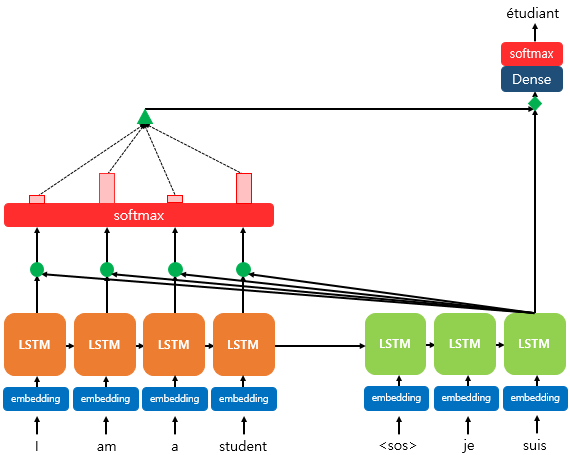</center>

# Reference
1. 어텐션 메커니즘 텐서플로  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention  
2. 어텐션 메커니즘 설명  
https://wikidocs.net/22893  
3. 텍스트 분석을 위한 어텐션 메커니즘  
https://wikidocs.net/72820  
4. 마크다운 이미지 resize  
https://blog.yena.io/studynote/2017/11/23/Github-resize-image.html  